# **미국의 의료비용 예측 데이터셋**
### 목차<br>
1. 데이터 분석 (이지수)
- 전체 데이터 분석<br>
- 흡연자를 중점으로 본 데이터 분석<br>
- 비흡연자를 중점으로 본 데이터 분석<br>
<br>
2. 정석적인 데이터 전처리와 모델링(박효준)<br>
- 각각 모델로 학습<br>
- 이상치 제거<br>
- 로그변환후 학습<br>
<br>
3. 데이터 세분화 이후 이상치 제거(김성일)<br>
- 모델링<br>
- 주의할점<br>
<br>
4. 다른 모델과 비교(박창민)<br>
- kaggle의 다른 코드와 비교

### 왜 모바일에서 의료비용 데이터셋으로 바뀌었나 ?
* 첫 프로젝트인 만큼 데이터셋을 구분하는 방법을 몰랐다는점
* 강사님과의 회의끝에 분석도중 모바일데이터엔 각 휴대폰모델의 오류/페이크데이터/target값과 모든 특성이 상관지수가 전혀 없다는 치명적인 오류가 있던 불량데이터셋 이라는것을 확인하였고, 데이터셋을 팀원과 합의하여 변경하였습니다

# **흡연자vs비흡연자 비교분석**

In [39]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures

%pip install catboost
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error


Note: you may need to restart the kernel to use updated packages.


In [40]:
# 1. 데이터 로드

HOME = os.getcwd()
datapath = os.path.join(HOME)
df = pd.read_csv(os.path.join(datapath, 'insurance.csv'))
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### **흡연자 수치형 컬럼별 시각화**


C:\Users\june4\AppData\Local\Temp\ipykernel_15744\501067556.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='charges', ax=axes[1, i], palette='Set3')
C:\Users\june4\AppData\Local\Temp\ipykernel_15744\501067556.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='smoker', y='charges', ax=axes[1, 2], palette='Pastel1')


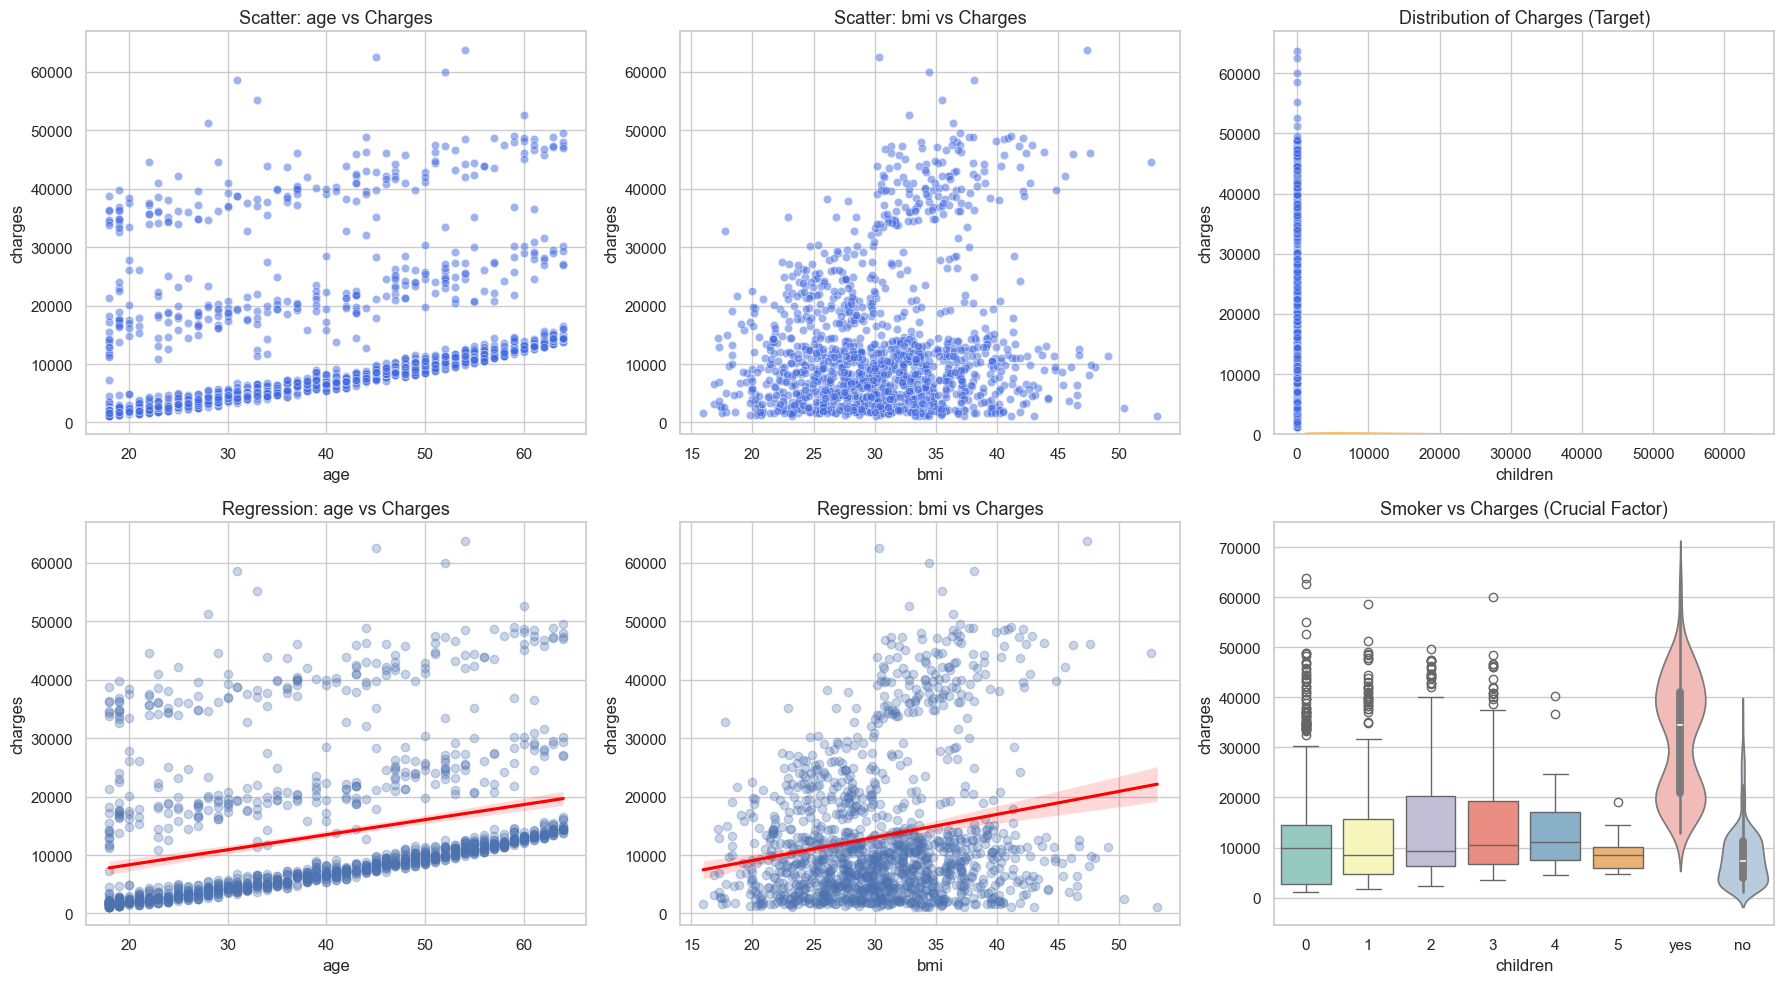

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 시각화할 특성 정의 (target인 charges는 제외)
features = ['age', 'bmi', 'children']
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # 2행 3열 설정

for i, col in enumerate(features):
    # --- 상단: 산점도 (데이터의 전체적인 분포와 경향성 확인) ---
    # x=컬럼, y='charges'로 고정
    sns.scatterplot(data=df, x=col, y='charges', ax=axes[0, i], alpha=0.5, color='royalblue')
    axes[0, i].set_title(f"Scatter: {col} vs Charges", fontsize=13)

    # --- 하단: 회귀선 또는 박스플롯 (추세 확인) ---
    if col == 'children':
        # 아이들 수는 범주형에 가까우므로 박스플롯이 보기 편합니다.
        sns.boxplot(data=df, x=col, y='charges', ax=axes[1, i], palette='Set3')
        axes[1, i].set_title(f"Boxplot: {col} vs Charges", fontsize=13)
    else:
        # age, bmi는 회귀선을 그려서 경향성을 확인합니다.
        sns.regplot(data=df, x=col, y='charges', ax=axes[1, i],
                    scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        axes[1, i].set_title(f"Regression: {col} vs Charges", fontsize=13)

# 나머지 빈 공간(2행 3열 중 마지막 칸)은 charges 자체의 분포를 그려줍니다.
sns.histplot(df['charges'], kde=True, ax=axes[0, 2], color='orange')
axes[0, 2].set_title("Distribution of Charges (Target)", fontsize=13)

sns.violinplot(data=df, x='smoker', y='charges', ax=axes[1, 2], palette='Pastel1')
axes[1, 2].set_title("Smoker vs Charges (Crucial Factor)", fontsize=13)

plt.tight_layout()
plt.show()

# **누가 의료비를 많이내는가?**
* charges와 상관관계를 Scatterplot 으로 보기
* 위 그래프를 토대로 bmi가 올라갈수록, age가 들수록 charges는 점점 올라가는것을 확인할 수 있다
* children은 2명일때가 charges값이 평균이 높았고, 이상치는 다양하게 분포되어있는걸을 확인할 수 있다
* 그리고 violin플롯을 보면 확연히 흡연자가 평균납부비용이 높다는것을 볼 수 있다
* **결론 = 흡연자/연장자/bmi 높은사람**

### **그래프로 봤을때 회귀선 테투리로 미세한 흐릿한 경계가 보입니다<br> 이는 모델의 예측값이 실제값과 얼마나 가까운지를 나타내며, 양쪽 끝은 흐릿한부분이 두꺼운 반면 가운데는 아주 얇은데, 얇을수록 데이터가 많다는 뜻입니다**
### **즉 어디에 데이터가 몰려있는지를 알수 있는 부분입니다**

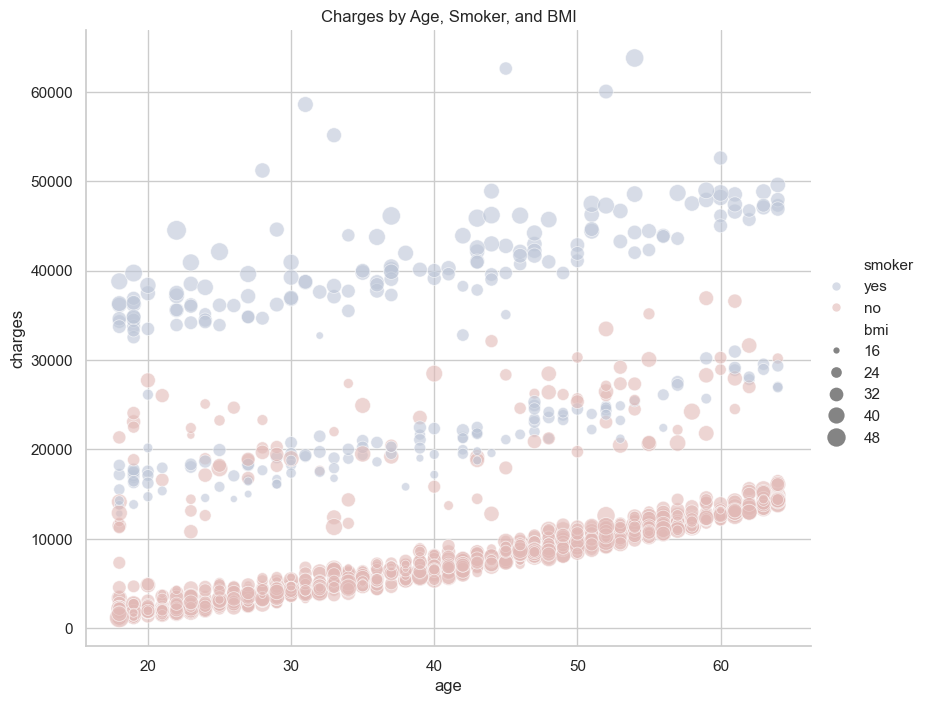

In [42]:
# relplot 을 사용하여 age/smoker/bmi가 charges에 어떤 영향이있는지 알아보기

sns.relplot(data=df,x='age', y='charges', hue='smoker', size='bmi',
    sizes=(20, 200), # 점 크기 범위 설정
    alpha=0.6,      # 점이 겹쳐도 보이게 투명도 조절
    palette='vlag',  # 색상 테마
    height=7,
    aspect=1.2)

plt.title('Charges by Age, Smoker, and BMI')
plt.show()

# 인사이트 찾기
* age와 bmi를 봤을때는 젊은사람에게도 고령자에게도 다양하게 bmi가 분포해있는것을 확인가능
* 위 그래프로 보아 bmi와 smoker는 상관관계가 있다
* 그러므로 둘 다 charges에도 상관관계가 있다
* smoke / bmi low 사람들은 1~20000 사이 분포
* smoke / bmi high 사람들은 최상단 분포
* non_smoker 는 bmi가 높아도 charges 하단분포
### 관계성은 smoker> age > bmi 이 순서로 해석가능함

C:\Users\june4\AppData\Local\Temp\ipykernel_15744\2065876044.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, ax=axes[0,i],palette='Set3')
C:\Users\june4\AppData\Local\Temp\ipykernel_15744\2065876044.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, ax=axes[0,i],palette='Set3')
C:\Users\june4\AppData\Local\Temp\ipykernel_15744\2065876044.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, ax=axes[0,i],palette='Set3')
C:\Users\june4\AppData\Local\Temp\ipykernel_15744\2065876044.py:8: Future

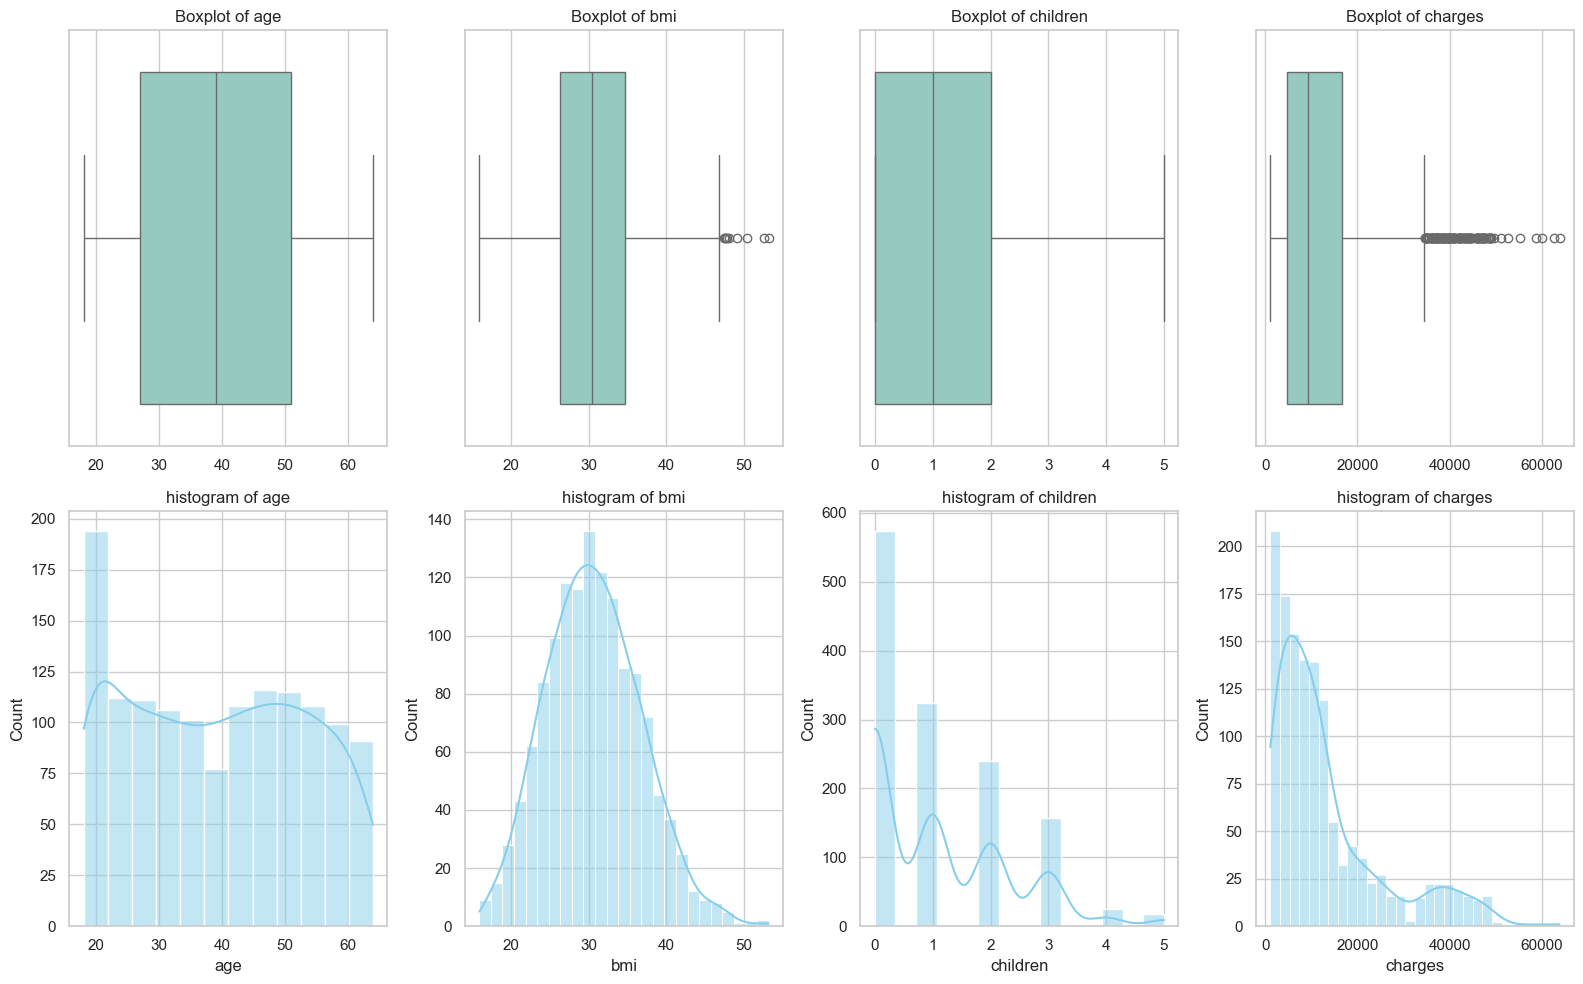

In [43]:
# 각 수치형 컬럼별 데이터분석 시각화
main_cols = ['age', 'bmi','children','charges']
# 각 수치형 데이터의 분포확인
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

for i ,col in enumerate(main_cols):
    # 상단 박스플롯
    sns.boxplot(data=df, x=col, ax=axes[0,i],palette='Set3')
    axes[0,i].set_title(f"Boxplot of {col}")
    axes[0,i].set_xlabel('')

    # 하단 histplot
    sns.histplot(data=df, x=col, kde=True, ax=axes[1,i], color='skyblue')# hue='charges'
    axes[1,i].set_title(f"histogram of {col}")

plt.tight_layout()
plt.show()

In [44]:
# 새로운특성 : 비만인 흡연자추가
df['is_obese_smoker'] = ((df['bmi'] >= 30) & (df['smoker'] == 'yes')).astype(int)

In [45]:
df.head()

,age,sex,bmi,children,smoker,region,charges,is_obese_smoker
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0


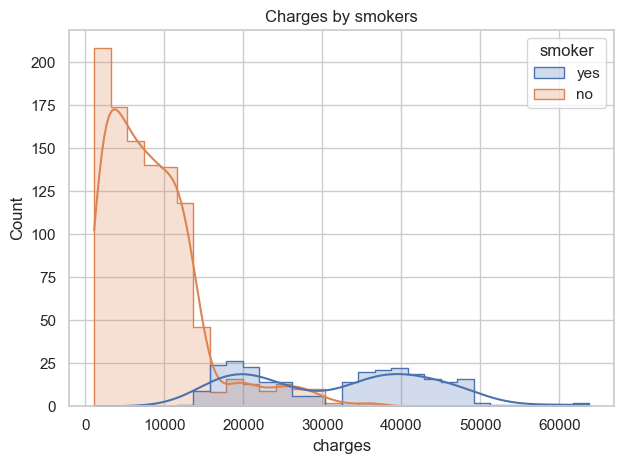

In [46]:
# smoker / non_smoker가 얼마나 금액이 차이나는지 보기편하게 hist이용하여 시각화

sns.histplot(data=df, x='charges', hue='smoker', kde=True,element='step')
plt.title('Charges by smokers')

plt.tight_layout()
plt.show()

### 흡연의 유무에 따라 비흡연자는 저가보험료, 흡연자는 고가보험료에 명확히 구분이 되어있음
### 비흡연자임에도 흡연자와 금액이 겹치는경우는 bmi의 수준이 높고, 고연령으로 예상됨

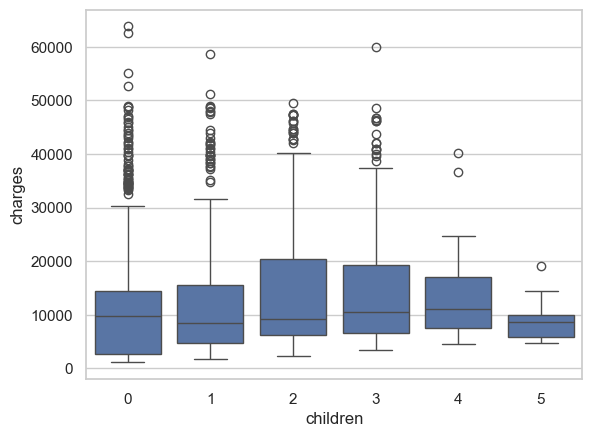

In [47]:
# 자녀수와 보험료의 관계

sns.boxplot(data=df, x='children', y='charges')
plt.show()

# 각 컬럼별 상관계수 확인해보기
## heatmap확인 전 범주형특성 one-hot encoding 으로 수치화

In [48]:
# 성별(sex), 지역(region), 흡연여부(smoker)를 한 번에 변환
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
# drop_first=True는 '남/여' 중 '여'가 0이면 당연히 '남'이므로 열 하나를 삭제해 용량을 줄입니다.
df_encoded.head()

# heatmap을 그리기 전에 데이터를 정규화합니다.

# True/False로 되어 있는 컬럼 이름들만 리스트로 만듭니다.
target_cols = ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']

# 해당 컬럼들만 int로 변환
df_encoded[target_cols] = df_encoded[target_cols].astype(int)
df_encoded.head()

,age,bmi,children,charges,is_obese_smoker,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,0,1,0,0,1
1,18,33.770,1,1725.55230,0,1,0,0,1,0
2,28,33.000,3,4449.46200,0,1,0,0,1,0
3,33,22.705,0,21984.47061,0,1,0,1,0,0
4,32,28.880,0,3866.85520,0,1,0,1,0,0


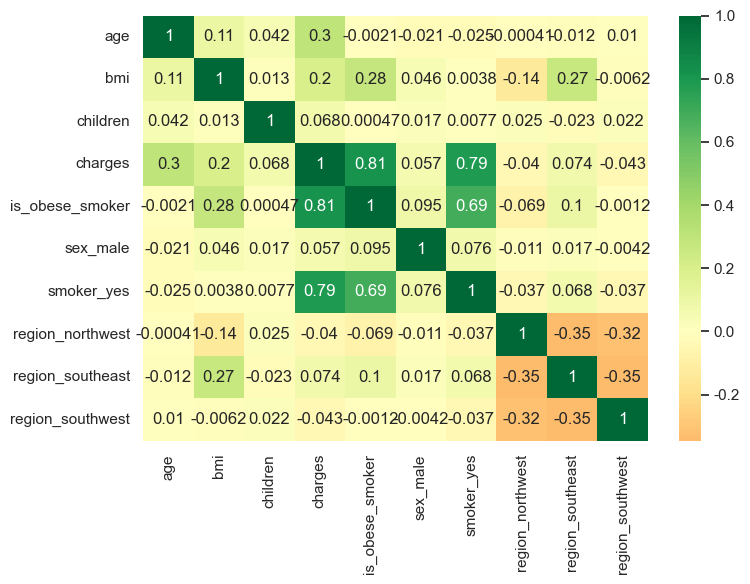

In [49]:
# heatmap 확인

plt.figure(figsize=(8, 6))
sns.heatmap(data=df_encoded.corr(), center=0, cmap='RdYlGn', annot=True)
plt.tight_layout()
plt.show()

* smoke_yes / bmi30이상,흡연자 / children(자녀수) 이 특성들이 상관계수가 높다

C:\Users\june4\AppData\Local\Temp\ipykernel_15744\41459163.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='region', y='bmi', palette='Set3')


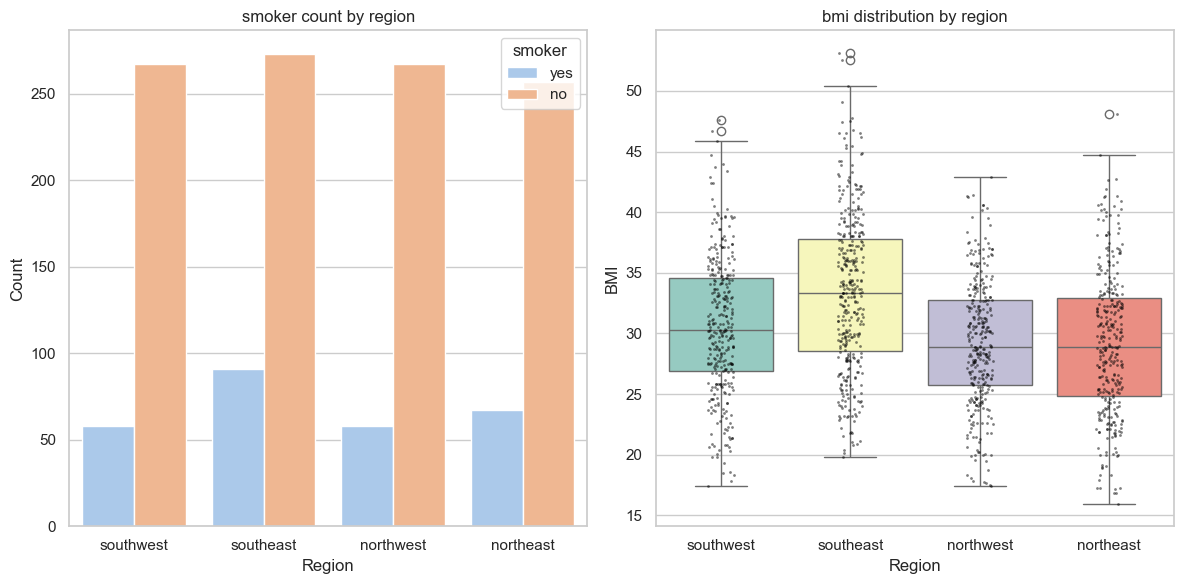

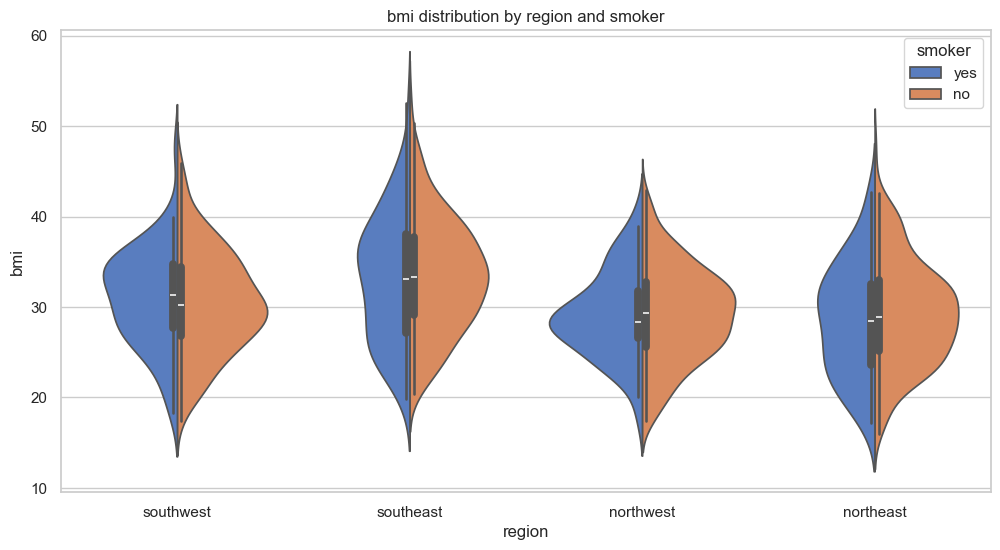

In [50]:
# 지역별 흡연자 / bmi지수 확인해보기
plt.figure(figsize=(12,6))
# 흡연자 지역분포 확인
plt.subplot(1,2,1)
sns.countplot(data=df, x='region',hue='smoker', palette='pastel')
plt.title('smoker count by region')
plt.xlabel('Region')
plt.ylabel('Count')

# 지역별 bmi분포(boxplot + stripplot)
plt.subplot(1,2,2)
sns.boxplot(data=df, x='region', y='bmi', palette='Set3')
# 실제 데이터 점들을 위에 살짝 뿌려주기
sns.stripplot(data=df, x='region', y='bmi', color='black',size=2,alpha=0.5)
plt.title('bmi distribution by region')
plt.xlabel('Region')
plt.ylabel('BMI')

plt.tight_layout()
plt.show()

# 지역별 '흡연자'들만의 BMI 분포 비교
plt.figure(figsize=(12,6))
sns.violinplot(data=df, x='region', y='bmi', hue='smoker',split=True, palette='muted')
plt.title('bmi distribution by region and smoker')
plt.show()

* 바이올린플롯의 가운데 흰색은 bmi의 중앙값
* 특정 지역의 흡연자들이 BMI까지 높다면" 그 지역 데이터는 의료비 예측에서 가장 높은 가중치가 있음
* southeast 지역의 흡연자가 제일 많고, bmi중앙값도 제일 높음<br>
**창민님께서 도메인지식을 위해 참고자료를 통해 실제 미국의 동남부지역이 비만율이 가장 높다는 기사를 찾아주셨습니다**
https://www.koreadaily.com/article/1463687

# 비흡연자에 대한 데이터분석

### **비흡연자의 의료비 증가를 이해하기 위한 도메인지식**
### *1. 노화에 따른 '기초대사량 저하'와 '만성 염증'의 결합*
##### 나이가 들면 우리 몸은 자연스럽게 기초대사량이 줄어들고 근육량이 감소합니다. 이때 BMI가 높다는 것은 단순한 체중 증가를 넘어, 체내 염증 수치가 일반인보다 훨씬 높음을 의미합니다.
##### 보험료와의 상관관계: 젊을 때는 신체가 이 염증을 어느 정도 견뎌내지만, 나이가 들면 누적된 염증이 혈관 건강을 악화시켜 심혈관 질환으로 이어집니다. 보험사는 이 **'누적된 위험의 폭발 가능성'**을 가격에 반영하는 것입니다.

### *2. '대사 증후군(Metabolic Syndrome)'의 가속화*
##### 데이터에서 BMI 30을 기준으로 보험료가 급격히 뛰는 구간이 발생하는 이유는 의학계에서 정의하는 **'대사 증후군'**의 임계점과 맞물려 있기 때문입니다.

##### 통계적 근거: 보험 통계(Actuarial Science)에 따르면,  나이(혈관 탄력 저하) + 높은 BMI(혈당 및 중성지방 상승) 이 두 변수가 결합할 때 의료비 지출은 산술적인 합이 아니라 **곱절(Multiplicative)**로 늘어납니다. 이것이 분석 결과에서 선형 회귀보다 트리 기반 모델(RandomForest)이 더 정확했던 이유이기도 합니다.

### *3. '회복 탄력성(Resilience)'과 만성 질환으로의 이행*
##### 젊은 층의 비만은 일시적인 현상일 수 있지만, 고연령층의 비만은 만성 질환으로 고착화될 확률이 압도적으로 높습니다.

##### 경제적 논리: 보험사는 현재의 건강 상태가 아니라, **'앞으로 남은 수명 동안 얼마나 많은 보험금을 지급해야 하는가'**를 계산합니다. 나이가 많고 BMI가 높으면 이 '잔여 기대 의료비' 수치가 급격히 상승합니다.

### *💡 설득을 위한 한 줄 요약*
##### "나이는 **'위험 노출 기간'**을 의미하고, 비만(BMI)은 **'위험의 강도'**를 의미합니다. 이 둘이 만나면 단순 합산이 아닌 복리(Compounding) 효과로 의료비 리스크가 커지기 때문에 보험료가 비싸질 수밖에 없습니다."

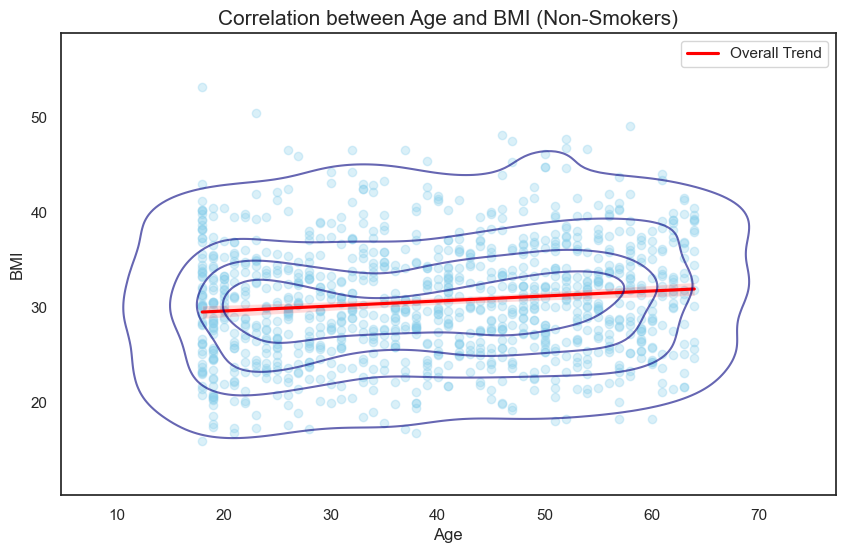

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 시각화 스타일 설정
sns.set_style("white")
plt.figure(figsize=(10, 6))

# 2. 비흡연자 데이터 필터링 (가장 깨끗한 패턴 확인을 위해)
non_smoker_df = df_encoded[df_encoded['smoker_yes']== 0]

# 3. 산점도와 밀도 그래프(KDE)를 결합
# - 점(Scatter)은 실제 데이터를 보여주고
# - 등고선(levels)은 데이터가 집중된 정도를 100, 200... 단위처럼 시각화합니다.
sns.regplot(data=non_smoker_df, x='age', y='bmi',
            scatter_kws={'alpha':0.3, 'color':'skyblue'},
            line_kws={'color':'red', 'label':'Overall Trend'})

sns.kdeplot(data=non_smoker_df, x='age', y='bmi',
            levels=5, color="navy", alpha=0.6, label='Density levels')

# 4. 그래프 꾸미기
plt.title("Correlation between Age and BMI (Non-Smokers)", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("BMI", fontsize=12)
plt.legend()

plt.show()

* 연령이 증가함에 따라 BMI 수치가 **미세하게** 동반 상승하는 경향을 확인하였으며, 이는 비흡연자 고연령층의 의료비 증가를 설명하는 요인으로인으로 판단됨


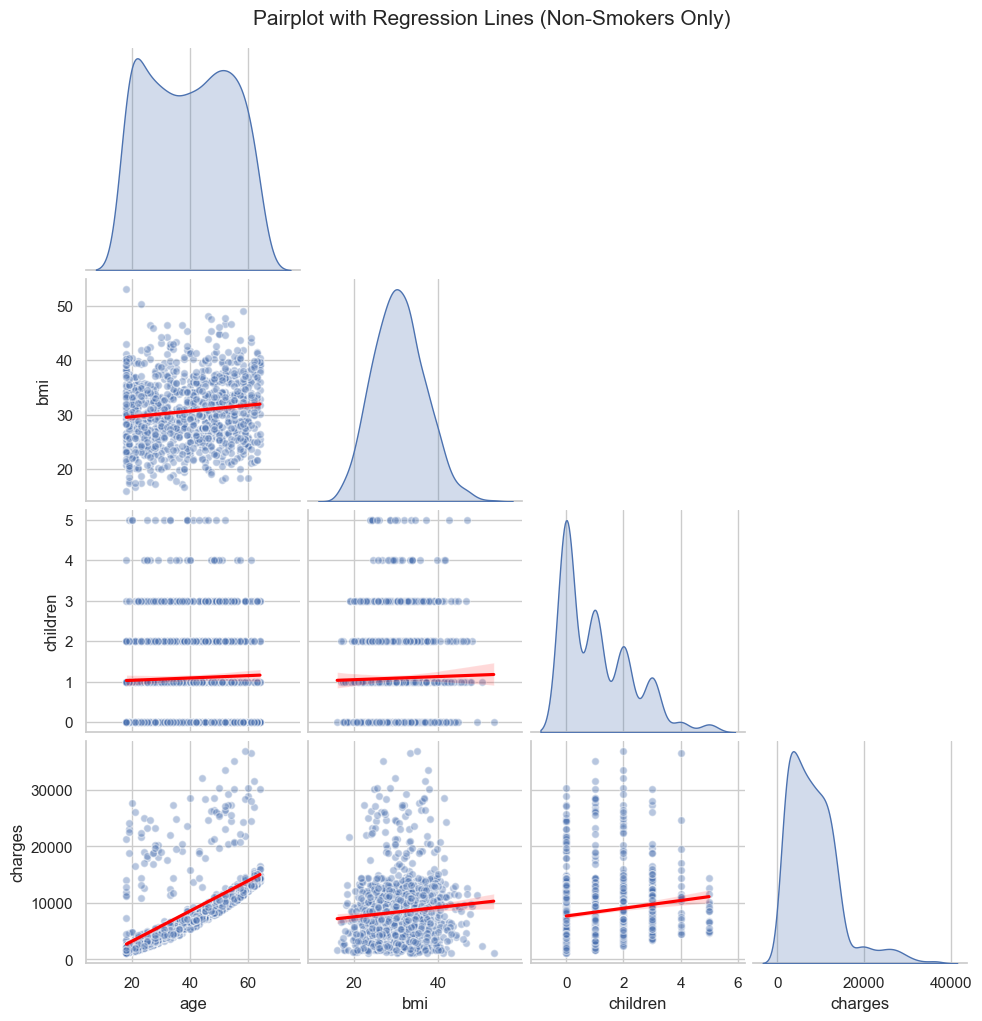

In [52]:
# # 비흡연자의 상관성을 각 컬럼별 그래프로 pairplot 이용하여 한 눈에 보기

non_smoker_df = df_encoded[df_encoded['smoker_yes'] == 0].copy()

# 분석에 필요한 주요컬럼들 선택
cols = ['age', 'bmi', 'children', 'charges']
sns.set_style('whitegrid')

# kind='reg' 를 추가하면 산점도 위에 회귀선(기울기)이 그려집니다.
g = sns.pairplot(non_smoker_df[cols],
                 kind='reg', # 회귀선 추가
                 diag_kind='kde',
                 plot_kws={
                     'line_kws':{'color':'red'}, # 기울기 선을 빨간색으로
                     'scatter_kws':{'alpha': 0.4, 's': 30, 'edgecolor': 'w'} # 점 설정
                 },
                 corner=True)

g.fig.suptitle('Pairplot with Regression Lines (Non-Smokers Only)', y=1.02, fontsize=15)

plt.show()

# **20,000달러 이상의 고액 구간에서 비흡연자가 많이 관찰되는 현상**
* **비흡연자 절대 수의 우위**와 **특정 위험 요인의 결합**이라는 두 가지 원인이 복합적으로 작용하고 있는걸 확인
* 위 그래프를 통해 비흡연자인 경우 children은 전혀 상관이없으며, bmi와age의 상관관계가 미세하게 우상향하는걸 확인
* charges와 charges에서 두구간으로 나뉘는걸 확인
* bmi와age의 데이터분포 및 다양하게 시각화 하여 어느정도 상관지수가 있는지 확인가능하다

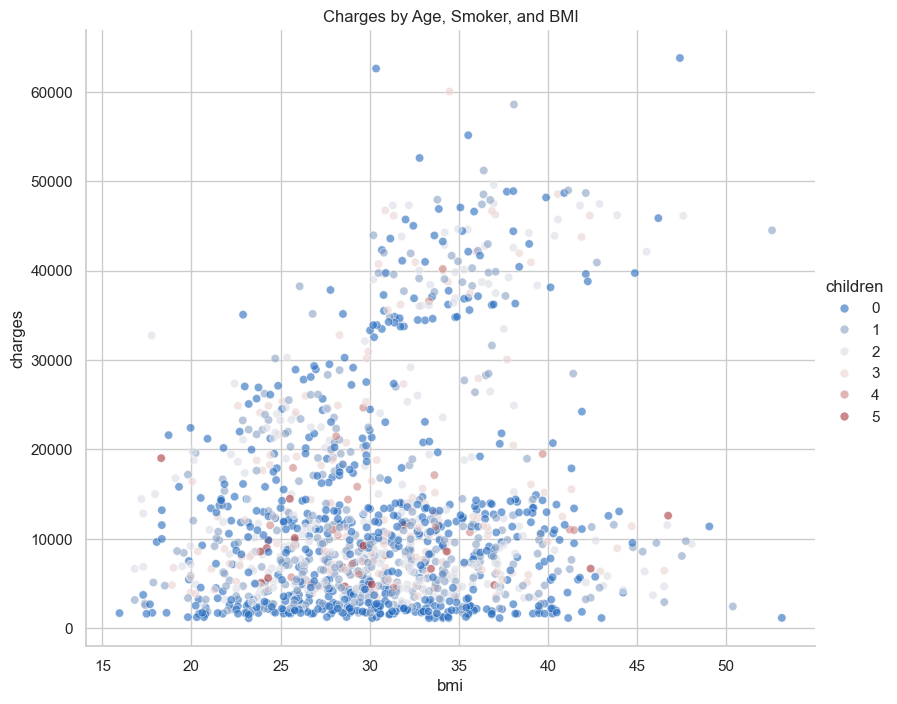

In [53]:
# children 과 bmi와 charges의 관계를 확인하기 위해 relplot을 사용

sns.relplot(data=df,x='bmi', y='charges', hue='children',
    sizes=(20, 200), # 점 크기 범위 설정
    alpha=0.6,      # 점이 겹쳐도 보이게 투명도 조절
    palette='vlag',  # 색상 테마
    height=7,
    aspect=1.2)

plt.title('Charges by Age, Smoker, and BMI')
plt.show()

### 결과 : 자녀수와bmi에 상관없이 다양하게 저액,고액에 분포되어있는걸 확인

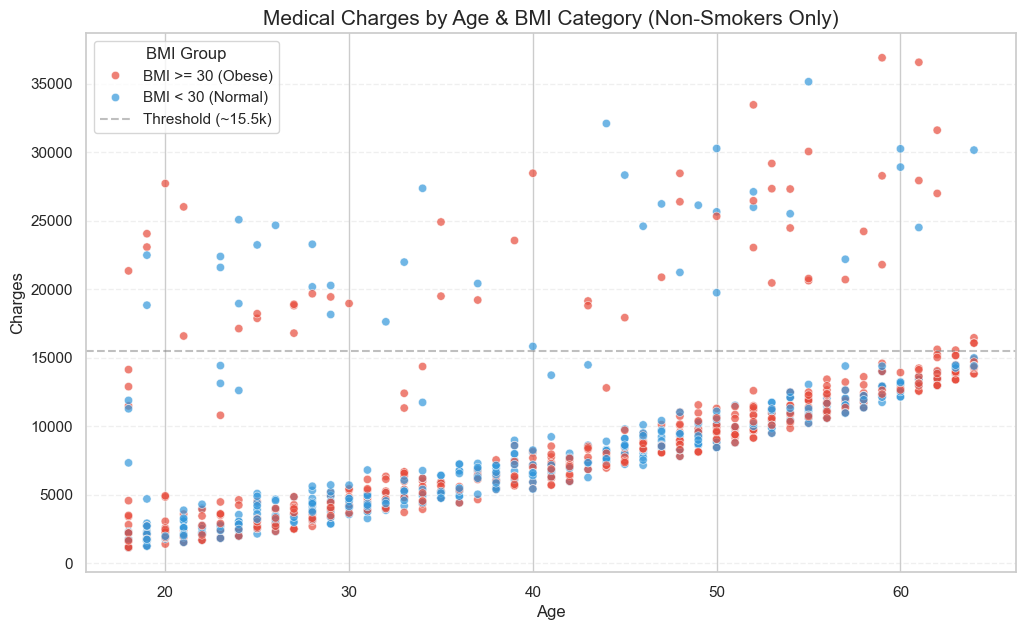

In [54]:
# 1. 비흡연자 데이터 필터링
non_smoker_df = df_encoded[df_encoded['smoker_yes'] == 0].copy()

# 2. BMI 30을 기준으로 그룹 생성 (비만 여부)
non_smoker_df['bmi_group'] = non_smoker_df['bmi'].apply(lambda x: 'BMI >= 30 (Obese)' if x >= 30 else 'BMI < 30 (Normal)')

# 3. 시각화
plt.figure(figsize=(12, 7))
sns.scatterplot(data=non_smoker_df,
                x='age',
                y='charges',
                hue='bmi_group',
                palette={'BMI >= 30 (Obese)': '#e74c3c', 'BMI < 30 (Normal)': '#3498db'},
                alpha=0.7)

# 4. 경계선 표시 (질문하신 15,000~16,000 구간)
plt.axhline(y=15500, color='gray', linestyle='--', alpha=0.5, label='Threshold (~15.5k)')

plt.title("Medical Charges by Age & BMI Category (Non-Smokers Only)", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Charges", fontsize=12)
plt.legend(title="BMI Group")
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

# **데이터분석 최종**
### 보험료 산정은 단일 지표(나이 혹은 흡연)만으로 판단할 수 없는 다층적 구조를 가집니다.
### 비흡연자라 하더라도 나이에 따른 BMI 관리가 이루어지지 않으면 고액 의료비 집단(15k~25k)으로 편입될 확률이 매우 높습니다
### 비흡연자에 관해선 age가 가장 큰 영향을 미친다.
* 위에서 보여졌듯이 자녀수와 지역은 관계가 없는것으로 판단 -  비흡연자 그룹 내 '제3의 변수' 존재 (데이터에 없는 원인)가 있는것으로 확인되었음
* 비흡연자 집단에서 15,500달러 이상의 고액 구간에 파란 점(BMI < 30)이 많다는 것 또한, 비만이 아니더라도 보험료를 폭발적으로 높이는 이 데이터에 없는 **다른 요인**이 있다는 증거입니다.

## 데이터 전처리와 모델링

* 머신러닝 모델은 문자열을 이해하지 못하므로, 범주형 데이터를 숫자로 변환하는 과정이 필수적입니다.
* LabelEncoder는 알파벳 순서대로 0부터 숫자를 부여하는 것

In [ ]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
le = LabelEncoder()

# 1. 성별(sex): female, male -> 0, 1 등으로 변환
df['sex'] = le.fit_transform(df['sex'])

# 2. 흡연 여부(smoker): no, yes -> 0, 1 등으로 변환
df['smoker'] = le.fit_transform(df['smoker'])

# 3. 지역(region): southwest, southeast, northwest, northeast -> 0, 1, 2, 3 등으로 변환
df['region'] = le.fit_transform(df['region'])

# 변환 결과 확인
print(df.head())

   age  sex     bmi  children  smoker  region      charges  is_obese_smoker
0   19    0  27.900         0       1       3  16884.92400                0
1   18    1  33.770         1       0       2   1725.55230                0
2   28    1  33.000         3       0       2   4449.46200                0
3   33    1  22.705         0       0       1  21984.47061                0
4   32    1  28.880         0       0       1   3866.85520                0


* 여자 = 0, 남자 = 1
* 흡연 여부 : no = 0, yes = 1
* Southwest (남서부), Southeast (남동부), Northwest (북서부), Northeast (북동부) -> 0, 1, 2, 3 으로 변환

In [56]:
# 1. 모델 리스트 정의 
models = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', Lasso()),
    ('Ridge', Ridge()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LGBM', LGBMRegressor(random_state=42, verbose=-1))
]

# 2. 전처리 전 '순수 원본' 데이터 준비
X_raw = df.drop('charges', axis=1)
y_raw = df['charges']

# 3. 데이터 분할
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

# 4. 결과 측정
raw_results = []
for name, model in models:
    model.fit(X_train_raw, y_train_raw)
    y_pred_raw = model.predict(X_test_raw)
    
    mae_raw = mean_absolute_error(y_test_raw, y_pred_raw)
    r2_raw = r2_score(y_test_raw, y_pred_raw)
    
    raw_results.append({
        'Model': name, 
        'MAE (Raw)': mae_raw, 
        'R2 Score (Raw)': r2_raw
    })

# 5. 결과 출력
raw_results_df = pd.DataFrame(raw_results).sort_values(by='MAE (Raw)', ascending=True)
print("=== [전처리 전] 순수 원본 데이터 모델 성능 ===")
display(raw_results_df.reset_index(drop=True))

=== [전처리 전] 순수 원본 데이터 모델 성능 ===


,Model,MAE (Raw),R2 Score (Raw)
0,Linear Regression,2474.313092,0.872326
1,Lasso,2474.418659,0.872334
2,Ridge,2476.993788,0.872530
3,Random Forest,2545.298264,0.858801
4,LGBM,2566.660742,0.862048
5,XGBoost,2781.009711,0.839716
6,Decision Tree,2882.483725,0.748969


* MAE(Mean Absolute Error, 평균 절대 오차) : 적을 수록 오차가 적음
MAE가 2975일 경우 2975달러 정도의 오차가 발생한 것

* R2 Score가 1에 가까울 수록 모델이 학습된 데이터에 대해 잘 예측했다는 의미

* 결측치 확인

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              1338 non-null   int64  
 1   sex              1338 non-null   int64  
 2   bmi              1338 non-null   float64
 3   children         1338 non-null   int64  
 4   smoker           1338 non-null   int64  
 5   region           1338 non-null   int64  
 6   charges          1338 non-null   float64
 7   is_obese_smoker  1338 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 83.8 KB


In [58]:
# 컬럼별 결측치 합계 계산
missing_values = df.isnull().sum()

print("=== 컬럼별 결측치 개수 ===")
print(missing_values)

=== 컬럼별 결측치 개수 ===
age                0
sex                0
bmi                0
children           0
smoker             0
region             0
charges            0
is_obese_smoker    0
dtype: int64


* charges 컬럼의 이상치를 확인합니다.

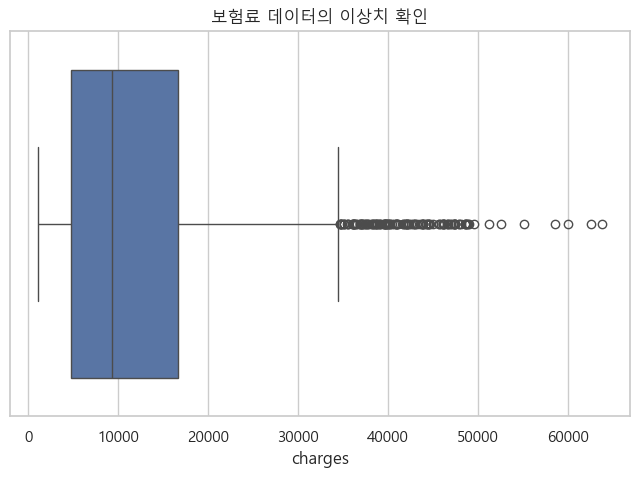

In [59]:
# 한글 폰트 설정 (Windows의 경우 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['charges'])
plt.title('보험료 데이터의 이상치 확인')
plt.show()

* 5만 달러 이상 내는 인원은 7명으로 확인

In [60]:
# 1. charges가 50,000 이상인 데이터
high_charges_df = df[df['charges'] >= 50000]

# 2. 결과 출력 (7명 확인)
print(f"보험료 $50,000 이상 인원 수: {len(high_charges_df)}명")
display(high_charges_df)

# 3. (선택 사항) 이들의 특징을 요약해서 보기
print("\n--- 고액 보험료 납부자 평균 정보 ---")
print(high_charges_df.describe())

보험료 $50,000 이상 인원 수: 7명


,age,sex,bmi,children,smoker,region,charges,is_obese_smoker
34,28,1,36.400,1,1,3,51194.55914,1
543,54,0,47.410,0,1,2,63770.42801,1
577,31,0,38.095,1,1,0,58571.07448,1
819,33,0,35.530,0,1,1,55135.40209,1
1146,60,1,32.800,0,1,3,52590.82939,1
1230,52,1,34.485,3,1,1,60021.39897,1
1300,45,1,30.360,0,1,2,62592.87309,1



--- 고액 보험료 납부자 평균 정보 ---
             age       sex        bmi  children  smoker    region  \
count   7.000000  7.000000   7.000000  7.000000     7.0  7.000000   
mean   43.285714  0.571429  36.440000  0.714286     1.0  1.714286   
std    12.671678  0.534522   5.445911  1.112697     0.0  1.112697   
min    28.000000  0.000000  30.360000  0.000000     1.0  0.000000   
25%    32.000000  0.000000  33.642500  0.000000     1.0  1.000000   
50%    45.000000  1.000000  35.530000  0.000000     1.0  2.000000   
75%    53.000000  1.000000  37.247500  1.000000     1.0  2.500000   
max    60.000000  1.000000  47.410000  3.000000     1.0  3.000000   

            charges  is_obese_smoker  
count      7.000000              7.0  
mean   57696.652167              1.0  
std     4863.802290              0.0  
min    51194.559140              1.0  
25%    53863.115740              1.0  
50%    58571.074480              1.0  
75%    61307.136030              1.0  
max    63770.428010              1.0  


* 7명은 평균적으로 나이가 43에 해당하며, 모두 흡연자이고 bmi 수치는 30이 넘어가는 걸로 확인.

### 3만 달러 이상 4만달러 이하로 보험료를 내는 사람들에 대해 확인해보겠습니다.

In [61]:
# 3만~4만 달러 구간 추출
group_30k_40k = df[(df['charges'] >= 30000) & (df['charges'] < 40000)]

print(f"=== 30,000 ~ 40,000달러 구간 (인원: {len(group_30k_40k)}명) ===")
if len(group_30k_40k) > 0:
    # 특징 평균값 확인
    print(group_30k_40k[['age', 'bmi', 'smoker', 'children']].mean())
    # 흡연자 비율 확인 (smoker가 1이면 흡연자)
    smoker_ratio = group_30k_40k['smoker'].value_counts(normalize=True)
    print(f"\n흡연 비율:\n{smoker_ratio}")
else:
    print("해당 조건의 데이터가 없습니다.")

=== 30,000 ~ 40,000달러 구간 (인원: 83명) ===
age         32.409639
bmi         33.060060
smoker       0.879518
children     1.036145
dtype: float64

흡연 비율:
smoker
1    0.879518
0    0.120482
Name: proportion, dtype: float64


* 평균 나이 32
* bmi지수 30이상
* 8~9명이 흡연자

### 4만 달러 이상 5만달러 이하로 보험료를 내는 사람들에 대해 확인해보겠습니다.

In [62]:
# 4만~5만 달러 구간 추출
group_40k_50k = df[(df['charges'] >= 40000) & (df['charges'] <= 50000)]

print(f"=== 40,000 ~ 50,000달러 구간 (인원: {len(group_40k_50k)}명) ===")
if len(group_40k_50k) > 0:
    # 특징 평균값 확인
    print(group_40k_50k[['age', 'bmi', 'smoker', 'children']].mean())
    # 흡연자 비율 확인
    smoker_ratio_high = group_40k_50k['smoker'].value_counts(normalize=True)
    print(f"\n흡연 비율:\n{smoker_ratio_high}")
else:
    print("해당 조건의 데이터가 없습니다.")

=== 40,000 ~ 50,000달러 구간 (인원: 72명) ===
age         49.277778
bmi         36.748542
smoker       1.000000
children     1.361111
dtype: float64

흡연 비율:
smoker
1    1.0
Name: proportion, dtype: float64


* 평균 나이 49
* bmi지수 30이상
* 72명 모두 흡연자로 확인

### 그러면 bmi가 30이 넘지 않고 흡연자도 아닌데 30000~50000달러 이하로 내는 사람들을 분류

In [63]:
# 조건 설정 (연속적인 필터링)
# 1. charges: 30,000 이상 ~ 50,000 이하
# 2. bmi: 30 미만
# 3. smoker: 0 (비흡연자)

condition_rare = (df['charges'] >= 30000) & (df['charges'] <= 50000) & \
                 (df['bmi'] < 30) & (df['smoker'] == 0)

rare_group = df[condition_rare]

# 결과 출력
print(f"초고위험 예외 케이스 인원: {len(rare_group)}명")
print("-" * 40)

if len(rare_group) > 0:
    print(rare_group)
else:
    print("해당 조건에 맞는 사람이 0명입니다.")
    print("즉, '비흡연자+BMI 30미만' 조합으로는 3만 달러 장벽을 넘기 어렵다는 방증입니다.")

초고위험 예외 케이스 인원: 5명
----------------------------------------
     age  sex     bmi  children  smoker  region      charges  is_obese_smoker
62    64    1  24.700         1       0       1  30166.61817                0
115   60    1  28.595         0       0       0  30259.99556                0
242   55    0  26.800         1       0       3  35160.13457                0
387   50    1  25.365         2       0       1  30284.64294                0
936   44    1  29.735         2       0       0  32108.66282                0


In [64]:
# [공통 코드] 이상치 제거 및 업데이트
outlier_condition = (df['charges'] >= 30000) & (df['charges'] <= 50000) & \
                    (df['bmi'] < 30) & (df['smoker'] == 0)

# 원본 df를 이상치가 제거된 데이터로 교체
df = df[~outlier_condition].reset_index(drop=True)

print(f"이상치 5명 제거 완료. 현재 전체 데이터 수: {len(df)}")

이상치 5명 제거 완료. 현재 전체 데이터 수: 1333


#### 생성형 AI의 추천으로 인한 로그 변환

In [65]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. 타겟 설정 (보험료) 및 로그 변환
# np.log1p를 사용하는 이유는 데이터에 0이 있더라도 에러를 방지하고 수치적 안정성을 높이기 위함입니다.
y_log = np.log1p(df['charges'])
X = df.drop('charges', axis=1)

# 2. 데이터 분할
# 로그 변환된 y_log를 사용하여 학습/테스트 세트를 나눕니다.
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

print("로그 변환 및 데이터 분할 완료!")
print(f"학습 데이터 모양: {X_train.shape}")
print(f"타겟 데이터 샘플(로그): \n{y_train_log.head()}")

로그 변환 및 데이터 분할 완료!
학습 데이터 모양: (1066, 7)
타겟 데이터 샘플(로그): 
1280    9.052009
1110    9.288087
966     8.515868
598     9.312133
170     7.435908
Name: charges, dtype: float64


#### 로그 변환의 차이

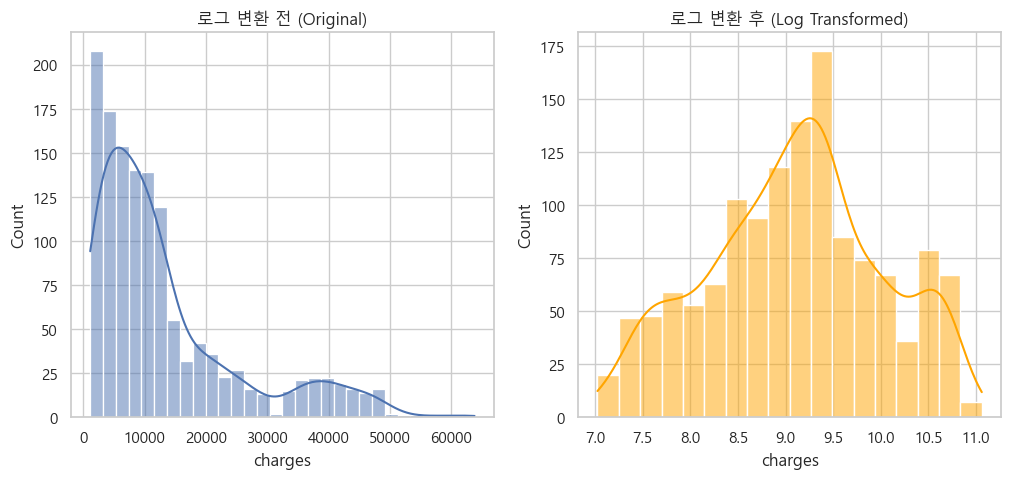

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# 변환 전
plt.subplot(1, 2, 1)
sns.histplot(df['charges'], kde=True)
plt.title('로그 변환 전 (Original)')

# 변환 후
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['charges']), kde=True, color='orange')
plt.title('로그 변환 후 (Log Transformed)')

plt.show()

* 쏠려 있는 데이터를 머신러닝 알고리즘이 더 학습하기 쉽도록 정규 분포에 가깝게 변환하는 것입니다.
* 변환 전: 데이터가 왼쪽으로 심하게 쏠려 있으면, 모델은 "아, 보험료는 보통 낮구나"라고만 생각하다가 가끔 나오는 고액 데이터를 만났을 때 크게 당황하며 오차를 냅니다.

* 변환 후 (정규화): 데이터가 종 모양이 되면, 모델이 낮은 금액부터 높은 금액까지의 변화 과정을 훨씬 안정적이고 논리적으로 학습할 수 있습니다.

In [67]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# 1. 비교할 모델 리스트업 (파라미터 포함)
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.01),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=0.01),
    "DecisionTree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBOOST": XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=42),
    "LGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
}

# 2. 반복문을 돌며 성적 측정
performance_results = []

for name, model in models.items():
    # 로그 변환된 타겟(y_train_log)으로 학습
    model.fit(X_train, y_train_log)

    # 예측 수행 (결과값도 로그 단위)
    log_predictions = model.predict(X_test)

    # 중요: 성능 평가를 위해 다시 원본 달러($) 단위로 복구 (np.expm1)
    real_predictions = np.expm1(log_predictions)
    real_y_test = np.expm1(y_test_log)

    performance_results.append({
        'model': name,
        'r2_score': r2_score(real_y_test, real_predictions),
        'mae': mean_absolute_error(real_y_test, real_predictions)
    })

# 3. 결과표 만들기 및 정렬 (R2는 높을수록, MAE는 낮을수록 좋음)
final_comparison_df = pd.DataFrame(performance_results).sort_values(by='r2_score', ascending=False)

print("=== 로그 변환 후 최종 모델 성능 비교 (원본 달러 단위 복구) ===")
display(final_comparison_df.reset_index(drop=True))

=== 로그 변환 후 최종 모델 성능 비교 (원본 달러 단위 복구) ===


,model,r2_score,mae
0,XGBOOST,0.913499,1551.753657
1,LGBM,0.902058,1795.496969
2,RandomForest,0.891082,1768.650790
3,DecisionTree,0.872880,1810.536533
4,ElasticNet,0.653794,3116.597294
5,Lasso,0.646697,3138.802183
6,Ridge,0.617861,3217.324695
7,LinearRegression,0.612899,3229.687201


#### 실제값 vs 예측값 산점도

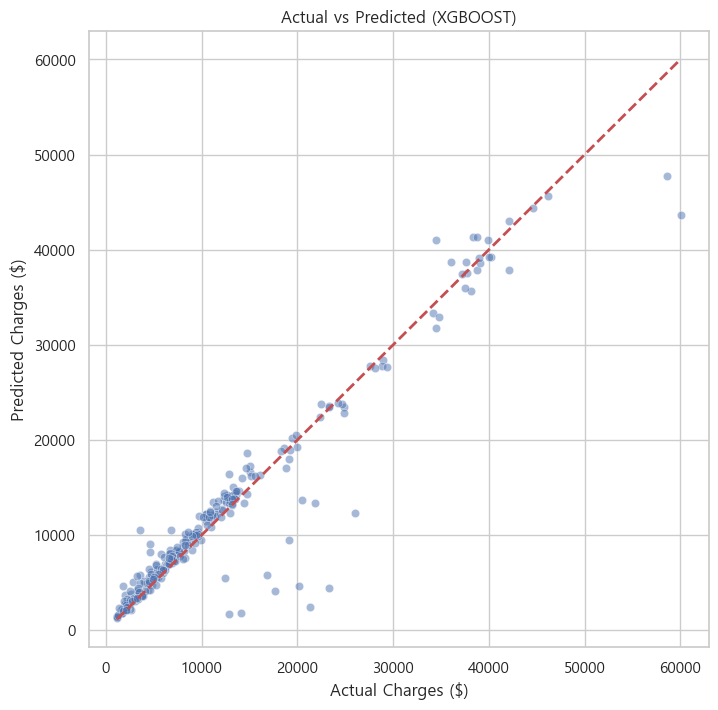

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 가장 성적이 좋았던 모델 선택 (예: XGBOOST)
# 만약 다른 모델을 보고 싶다면 models['RandomForest'] 등으로 바꾸면 됩니다.
best_model = models['XGBOOST']

# 2. 예측 수행 및 원본 단위 복구
y_pred_log = best_model.predict(X_test)
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

# 3. 그래프 그리기
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.5)

# 4. 45도 기준선 추가 (완벽한 예측일 때 점들이 위치하는 선)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', lw=2)

plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.title('Actual vs Predicted (XGBOOST)')
plt.show()

#### 산점도(Scatter Plot)에서 가로축은 실제 보험료, 세로축은 모델의 예측값입니다. 가운데 빨간 점선은 예측이 완벽하게 적중했을 때의 기준선입니다.보시는 바와 같이 대부분의 데이터가 기준선에 밀접하게 분포하고 있습니다. 이는 이상치 제거와 로그 변환 전처리가 모델의 예측 성능을 안정적으로 끌어올렸음을 증명합니다.


# **데이터중 이상치 분석**

* 위에선 개별적으로 봤을 떄 이해하기 힘든 특정 이상치만을 제거하는 과정을 가졌음
* 새로운 관점에서 재해석 - **보험료가 비슷해야 하는 구간끼리 묶어 이상치를 제거**

10단위의 나이별로 1차 분할, 흡연 여부에 따른 2차 분할, Bmi지수에 따라 3차 분할
분할된 그룹별 평균을 구하고 정규분포 95%를 남기고 이상치를 제거

즉 몇대, 흡연여부, Bmi정도를 다 세분화해 그룹화

Ex)
20대 비흡연자 저체중

20대 비흡연자 정상

20대 비흡연자 과체중

20대 비흡연자 전비만

20대 비흡연자 고도비만

20대 흡연자 저체중

20대 흡연자 정상

20대 흡연자 과체중

20대 흡연자 전비만

20대 흡연자 고도비만...

In [69]:

HOME = os.getcwd()
datapath = os.path.join(HOME)
df = pd.read_csv(os.path.join(datapath, 'insurance.csv'))
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [70]:
#  특성 공학 (Feature Engineering)
# 나이대 (10단위)
df['age_group'] = (df['age'] // 10) * 10

# BMI 카테고리 분류 (정교한 구간 설정)
bins = [0, 18.5, 23, 25, 30, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Pre-obese', 'Obese']
df['bmi_cat'] = pd.cut(df['bmi'], bins=bins, labels=labels)

# 핵심 변수: 고비만 흡연자 (BMI 30이상 & Smoker)
df['is_obese_smoker'] = ((df['bmi'] >= 30) & (df['smoker'] == 'yes')).astype(int)

#  세부 그룹별 이상치 제거 (95% 신뢰구간 기준)
def remove_group_outliers(group):
    if len(group) < 5:  # 샘플이 너무 적으면 이상치 계산 생략
        return group
    mean, std = group['charges'].mean(), group['charges'].std()
    lower, upper = mean - 1.96 * std, mean + 1.96 * std
    return group[(group['charges'] >= lower) & (group['charges'] <= upper)]

df_95remove = df.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)

print(f"이상치 제거 후 데이터 수: {len(df_95remove)}")

이상치 제거 후 데이터 수: 1247


C:\Users\june4\AppData\Local\Temp\ipykernel_15744\3954589417.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_95remove = df.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)
C:\Users\june4\AppData\Local\Temp\ipykernel_15744\3954589417.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_95remove = df.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)


#산점도로 확인하기

In [71]:
import scipy.stats as stats # Import the stats module

# 2. 영향력 큰 컬럼 추가 (흡연 + 고BMI: 30 이상)
# 흡연자이면서 BMI가 30 이상인 경우를 고위험군으로 분류
df['high_risk_smoker'] = ((df['smoker'] == 'yes') & (df['bmi'] >= 30)).astype(int)

# 3. 연령대 그룹 생성 (10대 단위)
df['age_group'] = (df['age'] // 10) * 10

# 4. BMI 5분법 적용
# 기준: ~18.5(저체중), ~25(정상), ~30(과체중), ~35(비만/전비만), 35~(고도비만)
bmi_bins = [0, 18.5, 25, 30, 35, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese']
df['bmi_group'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)

# 5. 세분화된 그룹별 이상치 탐지 (95% 신뢰구간 기준)
# 그룹화: 연령대 + 흡연여부 + BMI등급
group_cols = ['age_group', 'smoker', 'bmi_group']

def flag_outliers(group):
    # 신뢰도 95%는 z-score 기준 약 ±1.96
    # 그룹 내 샘플이 너무 적으면 계산이 무의미하므로 최소 3개 이상일 때만 계산
    if len(group) > 3:
        z_scores = np.abs(stats.zscore(group['charges']))
        # z-score가 1.96보다 크면 상위/하위 2.5% (합쳐서 5%)에 해당
        group['is_outlier'] = (z_scores > 1.96)
    else:
        group['is_outlier'] = False
    return group

# 그룹별로 함수 적용
df = df.groupby(group_cols, group_keys=False).apply(flag_outliers)

# 결과 확인
print(df[['age', 'smoker', 'bmi', 'bmi_group', 'high_risk_smoker', 'is_outlier']].head())
print(f"\n총 이상치 개수: {df['is_outlier'].sum()}개")

   age smoker     bmi   bmi_group  high_risk_smoker  is_outlier
0   19    yes  27.900  Overweight                 0       False
1   18     no  33.770       Obese                 0       False
2   28     no  33.000       Obese                 0       False
3   33     no  22.705      Normal                 0        True
4   32     no  28.880  Overweight                 0       False

총 이상치 개수: 97개


C:\Users\june4\AppData\Local\Temp\ipykernel_15744\2770984333.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(group_cols, group_keys=False).apply(flag_outliers)
C:\Users\june4\AppData\Local\Temp\ipykernel_15744\2770984333.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_cols, group_keys=False).apply(flag_outliers)


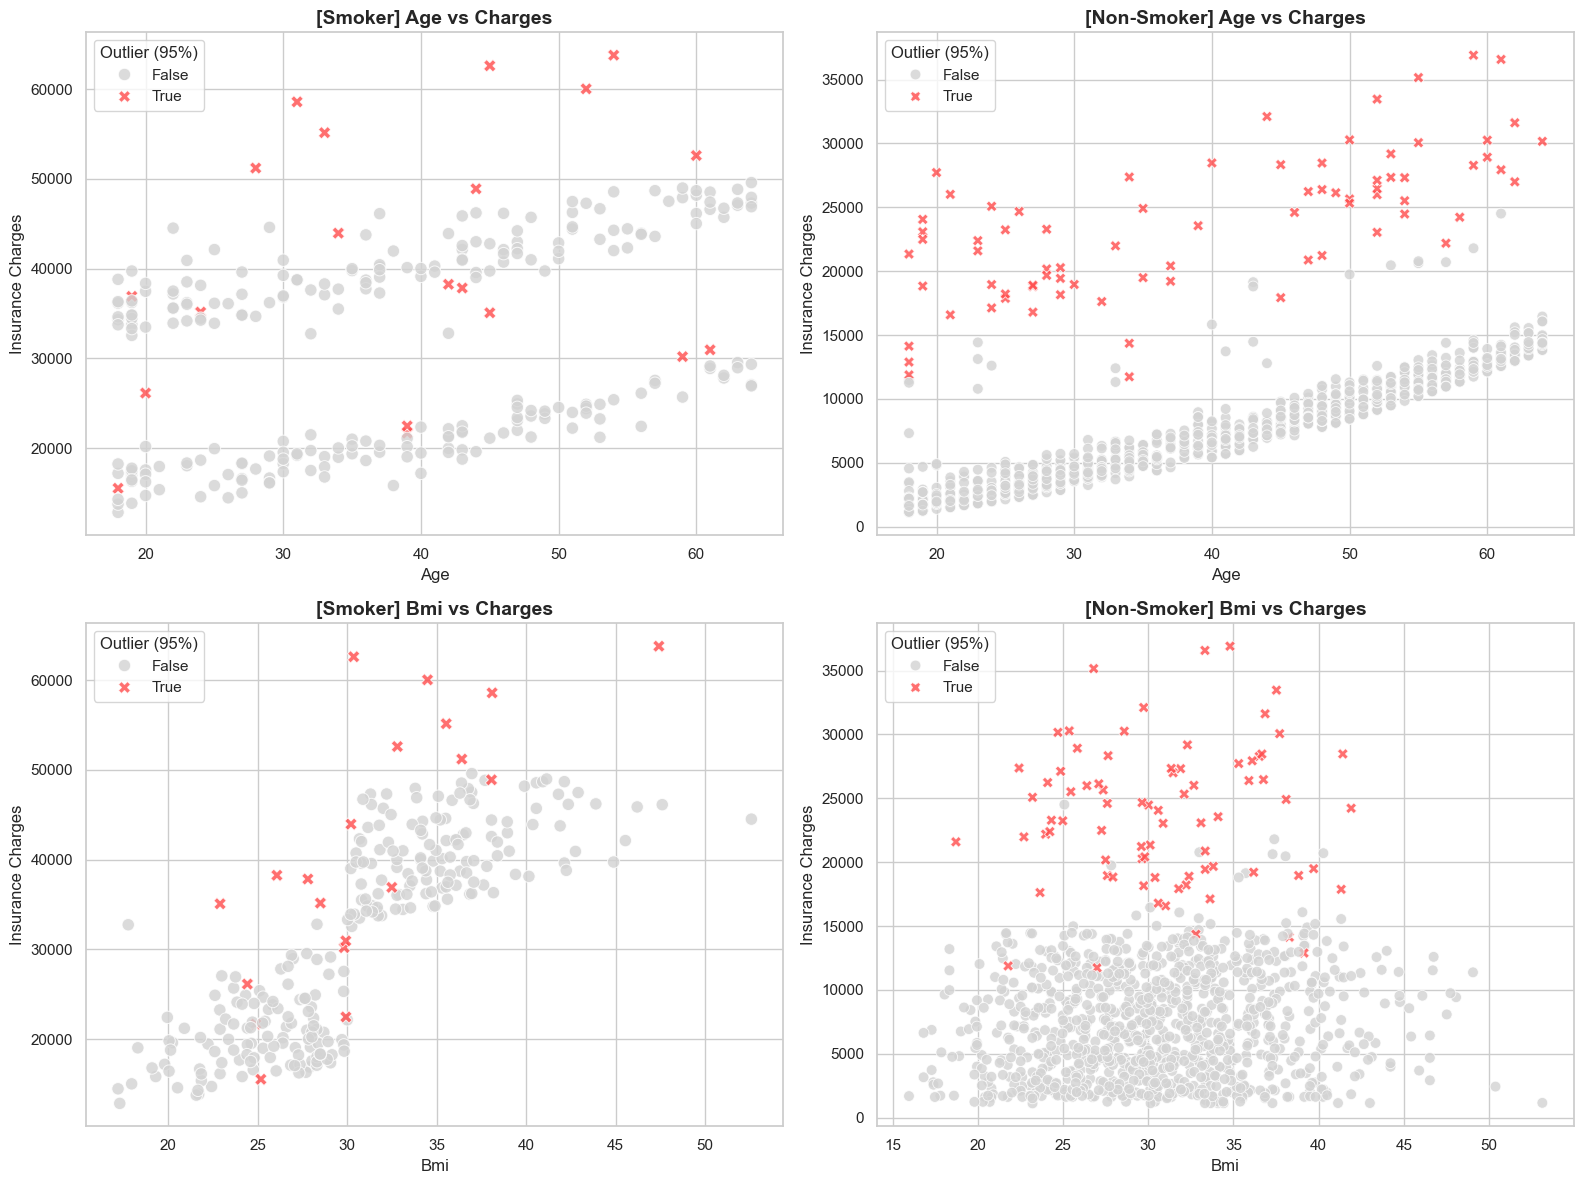

In [72]:
# 시각화 스타일 설정
sns.set_theme(style="whitegrid")

# 분석할 x축 리스트 (나이, BMI)
x_features = ['age', 'bmi']
smoker_types = ['yes', 'no']

# 그래프 생성 (2행 2열: x축 변수 2개 x 흡연여부 2개)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, x_col in enumerate(x_features):
    for j, smoker_val in enumerate(smoker_types):
        # 해당 조건의 데이터 필터링
        subset = df[df['smoker'] == smoker_val]

        # 산점도 그리기
        # hue='is_outlier'를 사용하여 이상치만 색상을 다르게 지정
        # palette: False는 연한 회색, True는 강렬한 빨간색으로 설정
        sns.scatterplot(
            data=subset,
            x=x_col,
            y='charges',
            hue='is_outlier',
            palette={False: 'lightgrey', True: '#FF4B4B'},
            style='is_outlier',
            markers={False: 'o', True: 'X'},
            alpha=0.8,
            s=60 if smoker_val == 'no' else 80, # 점 크기 조절
            ax=axes[i, j]
        )

        # 그래프 타이틀 및 라벨 설정
        status = "Smoker" if smoker_val == 'yes' else "Non-Smoker"
        axes[i, j].set_title(f"[{status}] {x_col.capitalize()} vs Charges", fontsize=14, fontweight='bold')
        axes[i, j].set_xlabel(x_col.capitalize())
        axes[i, j].set_ylabel('Insurance Charges')
        axes[i, j].legend(title='Outlier (95%)', loc='upper left')

plt.tight_layout()
plt.show()

# 제거된 이상치는 어떤 데이터일까?

세분화한 그룹중 하나를 예로들어, 20대 비흡연자이면서 Bmi가 정상범주에 속하지만 20대 비흡연자이면서 Bmi가 정상범주인 평균수치보다 보험료가 과하게 낮거나 과하게 높은 경우에 해당

예측==> 데이터셋 만으로는 알 수 없는 유전병, 기저질환, 수술이력등이 반영된 결과로 예측됨

In [73]:
import xgboost as xgb

#이상치 제거를 반영한 이후 모델링

# 인코딩 및 학습 준비
# 범주형 데이터 원-핫 인코딩
df_final = pd.get_dummies(df_95remove, columns=['sex', 'smoker', 'region', 'bmi_cat', 'age_group'], drop_first=True)

# 타겟 변수 로그 변환 (Charges의 왜도 해결)
X = df_final.drop(['charges'], axis=1)
y = np.log1p(df_final['charges'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# 평가 및 결과 역변환 (Log -> Original)
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

print("-" * 30)
print(f"📊 최종 결과 보고서")
print(f"이상치 제거 후 데이터 수: {len(df_95remove)}")
print(f"결정계수 (R2 Score): {r2_score(y_test_orig, y_pred):.4f}")
print(f"평균 절대 오차 (MAE): {mean_absolute_error(y_test_orig, y_pred):.2f}")
print("-" * 30)

------------------------------
📊 최종 결과 보고서
이상치 제거 후 데이터 수: 1247
결정계수 (R2 Score): 0.9746
평균 절대 오차 (MAE): 686.76
------------------------------


# 주의할 점!

해당 모델은 데이터로 분석이 힘든 이상치를 최대한 제거한 후 학습한 모델로 **평균적인 보험료**를 예측하는 모델임

이상치를 처음에 제거하는 것으로 특별한 사람들의 보험료를 예측하는 성적은 떨어지는 단점이 있으나, 데이터셋 만을 가지고 파악하기 힘든 요인을 제거하여 학습을 진행 평균적인 보험료를 예측하는데 중점을 둠

#각 모델을 활용해 가장 성능이 좋은 모델을 확인하기

In [74]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 모델들 임포트
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 1. 데이터 전처리 (보내주신 코드 반영)
# 범주형 데이터 원-핫 인코딩
df_final = pd.get_dummies(df_95remove, columns=['sex', 'smoker', 'region', 'bmi_cat', 'age_group'], drop_first=True)

# 타겟 변수 분리 및 로그 변환
X = df_final.drop(['charges'], axis=1)
y_log = np.log1p(df_final['charges'])

# 학습/테스트 데이터 분리
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 2. 비교할 모델 리스트업 (파라미터 최적화 반영)
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.01),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBOOST": XGBRegressor(n_estimators=1000, learning_rate=0.03, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42),
    "LGBM": LGBMRegressor(n_estimators=1000, learning_rate=0.03, random_state=42, verbose=-1)
}

# 3. 반복문 실행 및 성적 측정
performance_results = []

print(f"📊 분석 시작 (데이터 수: {len(df_95remove)}건)")
print("-" * 40)

for name, model in models.items():
    start_time = time.time()

    # 모델 학습
    model.fit(X_train, y_train_log)

    # 예측 및 로그 역변환
    y_pred_log = model.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    y_test_real = np.expm1(y_test_log)

    end_time = time.time()

    # 결과 저장
    performance_results.append({
        'Model': name,
        'R2 Score': r2_score(y_test_real, y_pred_real),
        'MAE': mean_absolute_error(y_test_real, y_pred_real),
        'RMSE': np.sqrt(mean_squared_error(y_test_real, y_pred_real)),
        'Time(s)': round(end_time - start_time, 3)
    })
    print(f"✅ {name} 학습 완료")

# 4. 최종 결과표 정리
final_comparison_df = pd.DataFrame(performance_results).sort_values(by='R2 Score', ascending=False)

print("\n=== 최종 모델 성능 비교 (원본 단위 복구 완료) ===")
display(final_comparison_df.reset_index(drop=True))

📊 분석 시작 (데이터 수: 1247건)
----------------------------------------
✅ LinearRegression 학습 완료
✅ Lasso 학습 완료
✅ Ridge 학습 완료
✅ RandomForest 학습 완료
✅ XGBOOST 학습 완료
✅ LGBM 학습 완료

=== 최종 모델 성능 비교 (원본 단위 복구 완료) ===


,Model,R2 Score,MAE,RMSE,Time(s)
0,RandomForest,0.975788,735.486047,1804.315562,0.436
1,XGBOOST,0.963185,821.394274,2224.879558,0.639
2,LGBM,0.959077,923.022088,2345.740313,0.534
3,Lasso,0.606896,2978.685852,7270.268550,0.005
4,Ridge,0.517549,3244.576717,8054.217521,0.005
5,LinearRegression,0.505049,3279.667225,8157.889307,0.009


#과적합 테스트

In [75]:
results_with_train = []

for name, model in models.items():
    # 학습 데이터 성적
    y_train_pred_log = model.predict(X_train)
    r2_train = r2_score(np.expm1(y_train_log), np.expm1(y_train_pred_log))

    # 테스트 데이터 성적 (기존 코드 활용)
    y_test_pred_log = model.predict(X_test)
    r2_test = r2_score(np.expm1(y_test_log), np.expm1(y_test_pred_log))

    results_with_train.append({
        'Model': name,
        'Train R2': round(r2_train, 4),
        'Test R2': round(r2_test, 4),
        'Gap': round(r2_train - r2_test, 4) # Gap이 클수록 과적합 위험
    })

overfit_df = pd.DataFrame(results_with_train).sort_values(by='Test R2', ascending=False)
print("=== 과적합 진단표 ===")
print(overfit_df)

=== 과적합 진단표 ===
              Model  Train R2  Test R2     Gap
3      RandomForest    0.9957   0.9758  0.0199
4           XGBOOST    0.9953   0.9632  0.0321
5              LGBM    0.9944   0.9591  0.0353
1             Lasso    0.6438   0.6069  0.0369
2             Ridge    0.5965   0.5175  0.0789
0  LinearRegression    0.5886   0.5050  0.0836


# 모델링의 완성

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. 데이터 로드
HOME = os.getcwd()
datapath = os.path.join(HOME)
df = pd.read_csv(os.path.join(datapath, 'insurance.csv'))
df.head()

# 2. 특성 공학 (Feature Engineering)
# 핵심: 도메인 지식을 반영한 파생 변수 생성
df['age_group'] = (df['age'] // 10) * 10
bins = [0, 18.5, 23, 25, 30, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Pre-obese', 'Obese']
df['bmi_cat'] = pd.cut(df['bmi'], bins=bins, labels=labels)

# 핵심 변수: 비만(BMI 30이상)이면서 흡연자인 경우 (상호작용 반영)
df['is_obese_smoker'] = ((df['bmi'] >= 30) & (df['smoker'] == 'yes')).astype(int)

# 3. 세부 그룹별 이상치 제거 (95% 신뢰구간 기준)
def remove_group_outliers(group):
    if len(group) < 5:
        return group
    mean, std = group['charges'].mean(), group['charges'].std()
    lower, upper = mean - 1.96 * std, mean + 1.96 * std
    return group[(group['charges'] >= lower) & (group['charges'] <= upper)]

df_cleaned = df.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)

# 4. 인코딩 및 학습 준비
# 범주형 데이터 원-핫 인코딩
df_final = pd.get_dummies(df_cleaned, columns=['sex', 'smoker', 'region', 'bmi_cat', 'age_group'], drop_first=True)

# 타겟 변수 로그 변환 (Charges의 왜도 해결)
X = df_final.drop(['charges'], axis=1)
y = np.log1p(df_final['charges'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. RandomForest 모델 학습
# 안정적인 예측을 위해 100개의 나무를 사용
final_rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
final_rf_model.fit(X_train, y_train)

# 6. 예측 및 결과 역변환 (Log -> Original Scale)
y_train_pred = np.expm1(final_rf_model.predict(X_train))
y_test_pred = np.expm1(final_rf_model.predict(X_test))
y_train_real = np.expm1(y_train)
y_test_real = np.expm1(y_test)

# 7. 최종 결과 보고 및 과적합 체크
print("-" * 40)
print(f"📊 [최종 모델 보고서: RandomForest]")
print(f"이상치 제거 후 데이터 수: {len(df_cleaned)}")
print(f"Train R2 Score: {r2_score(y_train_real, y_train_pred):.4f}")
print(f"Test  R2 Score: {r2_score(y_test_real, y_test_pred):.4f}")
print(f"MAE (오차 금액): ${mean_absolute_error(y_test_real, y_test_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_real, y_test_pred)):.2f}")
print(f"과적합 간격(Gap): {abs(r2_score(y_train_real, y_train_pred) - r2_score(y_test_real, y_test_pred)):.4f}")
print("-" * 40)

C:\Users\june4\AppData\Local\Temp\ipykernel_15744\2167765767.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cleaned = df.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)
C:\Users\june4\AppData\Local\Temp\ipykernel_15744\2167765767.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)


----------------------------------------
📊 [최종 모델 보고서: RandomForest]
이상치 제거 후 데이터 수: 1247
Train R2 Score: 0.9957
Test  R2 Score: 0.9758
MAE (오차 금액): $735.49
RMSE: 1804.32
과적합 간격(Gap): 0.0199
----------------------------------------
